Syntactic and Lexical Features for Sentiment Analysis      

In [1]:
# Mount your google drive in google colab
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 0. Import Dependencies and Data

In [2]:
#Working away Colab


# !pip install tensorflow tensorflow-gpu pandas matplotlib sklearn

# import os
# import pandas as pd
# import tensorflow as tf
# import numpy as np

In [3]:
import pandas as pd

In [4]:
#import train and test splits

df_train = pd.read_csv("/content/drive/MyDrive/SLF4SA/tass2020_emotion_train.csv")
df_valid = pd.read_csv("/content/drive/MyDrive/SLF4SA/tass2020_emotion_dev.csv")

print(df_train.shape, "\n", df_valid.shape)

(5886, 3) 
 (857, 3)


In [5]:
df_train.head(5)

,id,tweet,label
0,1,El Atlético resignado a perder HASHTAG 😔 http...,sadness
1,2,Leer proporciona una mejor visión del mundo 🤓 ...,joy
2,3,Amo a Arya Stark por encima de todas las cosas...,joy
3,4,Gracias HASHTAG es increíble que una niña logr...,others
4,5,Solo siento que hayamos perdido 24 escaños de ...,sadness


In [6]:
#Classs distribution

df_train['label'].value_counts()

others       2888
joy          1270
sadness       706
anger         600
surprise      241
disgust       113
fear           67
others          1
Name: label, dtype: int64

In [7]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5886 entries, 0 to 5885
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      5886 non-null   int64 
 1   tweet   5886 non-null   object
 2   label   5886 non-null   object
dtypes: int64(1), object(2)
memory usage: 138.1+ KB


# 1. Data Preprocessing

In [8]:
import re
from sklearn.preprocessing import LabelEncoder

In [9]:
!pip install clean-text

In [10]:
from cleantext import clean

Since the GPL-licensed package `unidecode` is not installed, using Python's `unicodedata` package which yields worse results.


In [11]:
#Preprocessing functions

def remove_links(tweet):
    """Takes a string and removes web links from it"""
    tweet = re.sub(r'http\S+', '', tweet)   # remove http links
    tweet = re.sub(r'bit.ly/\S+', '', tweet)  # remove bitly links
    tweet = tweet.strip('[link]')   # remove [links]
    tweet = re.sub(r'pic.twitter\S+','', tweet)
    return tweet

def remove_users(tweet):
    """Takes a string and removes retweet and @user information"""
    tweet = re.sub('(RT\s@[A-Za-z]+[A-Za-z0-9-_]+)', '', tweet)  # remove re-tweet
    tweet = re.sub('(@[A-Za-z]+[A-Za-z0-9-_]+)', '', tweet)  # remove tweeted at
    return tweet

def remove_hashtags(tweet):
    """Takes a string and removes any hash tags"""
    tweet = re.sub('(#[A-Za-z]+[A-Za-z0-9-_]+)', '', tweet)  # remove hash tags
    return tweet

def remove_av(tweet):
    """Takes a string and removes AUDIO/VIDEO tags or labels"""
    tweet = re.sub('VIDEO:', '', tweet)  # remove 'VIDEO:' from start of tweet
    tweet = re.sub('AUDIO:', '', tweet)  # remove 'AUDIO:' from start of tweet
    return tweet

def remove_emoji(tweet):
    """Remove emojis"""
    tweet = clean(tweet, no_emoji=True)
    return tweet

def preprocessing(text):
    text = remove_links(text)
    text = remove_users(text)
    text = remove_hashtags(text)
    text = remove_av(text)
    text = remove_emoji(text)
    return text

In [12]:
df_train_prep = df_train.copy()
df_valid_prep = df_valid.copy()

In [13]:
df_train_prep['label'].value_counts().index

Index(['others ', 'joy ', 'sadness ', 'anger ', 'surprise ', 'disgust ',
       'fear ', 'others'],
      dtype='object')

In [14]:
#delete the row that contains only a single value for a class

df_train_prep = df_train_prep[df_train_prep.label != 'others']
df_train_prep['label'].value_counts().index

Index(['others ', 'joy ', 'sadness ', 'anger ', 'surprise ', 'disgust ',
       'fear '],
      dtype='object')

In [15]:
df_train_prep['tweet'] = df_train_prep['tweet'].apply(preprocessing)
df_valid_prep['tweet'] = df_valid_prep['tweet'].apply(preprocessing)

## 1.1 Encode the output variable

In [16]:
# df_train_prep['label'].value_counts()

In [17]:
# yle = LabelEncoder()

# #Encode train split
# df_train_prep['label'] = yle.fit_transform(df_train_prep['label'])

# df_train_prep['label'].value_counts()

In [18]:
# df_valid_prep['label'].value_counts()

In [19]:
# #Encode test split

# df_valid_prep['label'] = yle.fit_transform(df_valid_prep['label'])
# df_valid_prep['label'].value_counts()

In [20]:
X_train = df_train_prep['tweet']
y_train = df_train_prep['label']

X_valid = df_valid_prep['tweet']
y_valid = df_valid_prep['label']

print(X_train.shape, y_train.shape, X_valid.shape, y_valid.shape)

(5885,) (5885,) (857,) (857,)


In [21]:
from keras.utils import np_utils

In [22]:
# encode class values as integers
encoder = LabelEncoder()

#y_train
encoder.fit(y_train)
encoded_y_train = encoder.transform(y_train)
# convert integers to dummy variables (i.e. one hot encoded)
y_train = np_utils.to_categorical(encoded_y_train)

#y_valid
encoder.fit(y_valid)
encoded_y_valid = encoder.transform(y_valid)
# convert integers to dummy variables (i.e. one hot encoded)
y_valid = np_utils.to_categorical(encoded_y_valid)

print(y_train.shape, y_valid.shape)

(5885, 7) (857, 7)


# 2. Feature Extraction

## 2.1 Vectorization

In [23]:
from tensorflow.keras.layers import TextVectorization

In [24]:
MAX_FEATURES = 200000 # number of words in the vocab

In [25]:
vectorizer = TextVectorization(max_tokens=MAX_FEATURES,
                               output_sequence_length=1800,
                               output_mode='int')

In [26]:
vectorizer.adapt(X_train.values)

In [27]:
#Words in the adapted vectorizer (vocabulary)
vectorizer.get_vocabulary()

['',
 '[UNK]',
 'hashtag',
 'de',
 'que',
 'la',
 'el',
 'y',
 'en',
 'a',
 'user',
 'no',
 'los',
 'es',
 'se',
 'un',
 'por',
 'con',
 'del',
 'lo',
 'para',
 'una',
 'las',
 'al',
 'me',
 'mas',
 'esta',
 'como',
 'su',
 'si',
 'hoy',
 'pero',
 'ha',
 'mi',
 'este',
 'mejor',
 'ya',
 'ver',
 'todo',
 'dia',
 'todos',
 'nos',
 'libro',
 'hay',
 'solo',
 'capitulo',
 'mundo',
 'te',
 'le',
 'muy',
 'o',
 'anos',
 'ser',
 'messi',
 'historia',
 'gracias',
 'sin',
 'son',
 'sus',
 'cuando',
 'he',
 'contra',
 'asi',
 'ahora',
 'incendio',
 'porque',
 'catedral',
 'han',
 'libros',
 'hace',
 'feliz',
 'tu',
 'yo',
 'gente',
 'esto',
 'vez',
 'desde',
 'ni',
 'sobre',
 'puede',
 'pais',
 'va',
 'espana',
 'noche',
 'tiene',
 'triste',
 'bien',
 'pueblo',
 'perdida',
 'nada',
 'pena',
 'estoy',
 'final',
 'fue',
 'siempre',
 'quien',
 'estan',
 'barcelona',
 'da',
 'les',
 'gran',
 'vida',
 'tan',
 'hacer',
 'gol',
 'bueno',
 'campeon',
 'mucho',
 'mis',
 'leer',
 'despues',
 'tiempo',
 'e

In [28]:
X_train_vectorized_text = vectorizer(X_train.values)
X_valid_vectorized_text = vectorizer(X_valid.values)

print(X_train_vectorized_text.shape, X_valid_vectorized_text.shape, y_train.shape, y_valid.shape)

(5885, 1800) (857, 1800) (5885, 7) (857, 7)


In [53]:
X_train_vectorized_text[0]

<tf.Tensor: shape=(1800,), dtype=int64, numpy=array([   6,  759, 6706, ...,    0,    0,    0])>

# 3. Create Model (NN Architecture)

In [73]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Bidirectional, Dense, Embedding

from tensorflow.keras.utils import plot_model

In [97]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=5, # how many epochs to wait before stopping
    restore_best_weights=True,
)

In [111]:
model = Sequential()
# Create the embedding layer 
model.add(Embedding(MAX_FEATURES+1, 32))
# Bidirectional LSTM Layer
model.add(Bidirectional(LSTM(32, activation='tanh')))
# Feature extractor Fully connected layers
model.add(Dense(128, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
# Final layer 
model.add(Dense(7, activation='sigmoid'))

In [112]:
model.compile(loss='BinaryCrossentropy', optimizer='Adam', metrics=['binary_accuracy'])

In [113]:
model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_11 (Embedding)    (None, None, 32)          6400032   
                                                                 
 bidirectional_11 (Bidirecti  (None, 64)               16640     
 onal)                                                           
                                                                 
 dense_45 (Dense)            (None, 128)               8320      
                                                                 
 dense_46 (Dense)            (None, 256)               33024     
                                                                 
 dense_47 (Dense)            (None, 128)               32896     
                                                                 
 dense_48 (Dense)            (None, 7)                 903       
                                                     

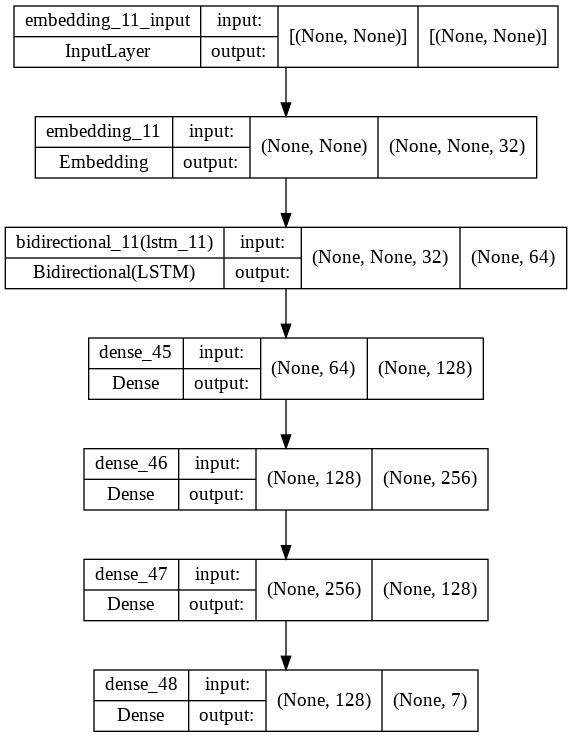

In [114]:
plot_model(model, to_file = 'model.jpg' , show_shapes=True)

In [115]:
history = model.fit(X_train_vectorized_text,
                    y_train,
                    validation_data=(X_valid_vectorized_text, y_valid),
                    epochs=30,
                    callbacks=[early_stopping],
                    )

Epoch 1/30
184/184 [==============================] - 22s 102ms/step - loss: 0.3436 - binary_accuracy: 0.8581 - val_loss: 0.2994 - val_binary_accuracy: 0.8758
Epoch 2/30
184/184 [==============================] - 18s 98ms/step - loss: 0.2684 - binary_accuracy: 0.8932 - val_loss: 0.2788 - val_binary_accuracy: 0.8900
Epoch 3/30
184/184 [==============================] - 18s 98ms/step - loss: 0.2157 - binary_accuracy: 0.9139 - val_loss: 0.2973 - val_binary_accuracy: 0.8875
Epoch 4/30
184/184 [==============================] - 19s 102ms/step - loss: 0.1706 - binary_accuracy: 0.9314 - val_loss: 0.3286 - val_binary_accuracy: 0.8660
Epoch 5/30
184/184 [==============================] - 18s 98ms/step - loss: 0.1329 - binary_accuracy: 0.9496 - val_loss: 0.3532 - val_binary_accuracy: 0.8821
Epoch 6/30
184/184 [==============================] - 18s 98ms/step - loss: 0.1043 - binary_accuracy: 0.9622 - val_loss: 0.4021 - val_binary_accuracy: 0.8790
Epoch 7/30
184/184 [==============================

# 4. Result

In [116]:
from matplotlib import pyplot as plt

Best Validation Loss: 0.2788
Best Validation Accuracy: 0.8900


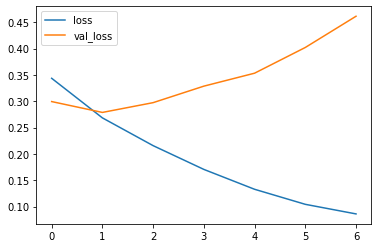

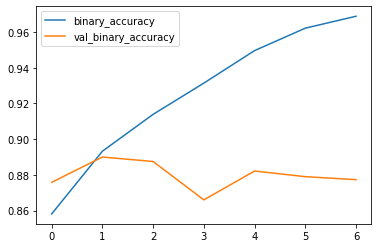

In [117]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()
history_df.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot()

print(("Best Validation Loss: {:0.4f}" +\
      "\nBest Validation Accuracy: {:0.4f}")\
      .format(history_df['val_loss'].min(), 
              history_df['val_binary_accuracy'].max()))